In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

In [ ]:
!pip install smogn #install smogn package

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xgboost as xg 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
import sklearn.model_selection
sklearn.model_selection.KFold
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

In [ ]:
#path of input files for sulphur, p/n/a

# df = pd.read_excel("/content/drive/My Drive/All_sul_training.xlsx")
df = pd.read_excel("/content/drive/My Drive/Exxon_Aromatics.xlsx")
# df = pd.read_excel("/content/drive/My Drive/Paper 2 Excel Files/Exxon_PN.xlsx")

df = df.fillna(0.0) #fill all na values with 0 

In [ ]:
len(df) #check length of dataframe 

515

In [ ]:
import smogn

In [ ]:
ov_df = smogn.smoter(data = df, y = 'Sulfur, wt%') #apply smogn technique on dataset to get new dataset 

r_index: 100%|##########| 48/48 [00:00<00:00, 500.42it/s]


In [ ]:
len(ov_df) #check length of dataset after smogn 

410

In [ ]:
df.columns # check columns

Index(['API Gravity,  ', 'IBP, C', '5 vol%, C', '10 vol%, C', '20 vol%, C',
       '30 vol%, C', '40 vol%, C', '50 vol%, C', '60 vol%, C', '70 vol%, C',
       '80 vol%, C', '90 vol%, C', '95 vol%, C', 'EP, C', 'Sulfur, wt%'],
      dtype='object')

In [ ]:
df.drop(['Crude Name', 0, 'Specific Gravity (60/60F),  ', 'Crude Name'], axis = 1, inplace = True) # drop unnecesary columns 

In [ ]:
df = df.sample(frac=1).reset_index(drop=True) # randomly shuffly the dataset 

In [ ]:
#OUTLIER CLIPPING

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
# Get X and y 

# X, y = ov_df.iloc[:, :-1].values, ov_df.iloc[:, -1].values # sulphur
# X, y = df.iloc[:, 2:], df.iloc[:, 1] # naphthenes 
# X, y = df.iloc[:, 2:], df.iloc[:, 0] # paraffins
X, y = df.iloc[:, 1:], df.iloc[:, 0] # aromatics

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


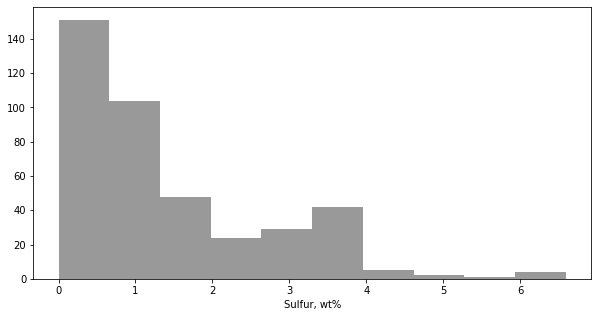

In [ ]:
#DISTIBUTION PLOT to see the frequency distribution of the dependent variable

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))  
freq=ov_df['Sulfur, wt%'].dropna()
sns.distplot(freq,bins=10,kde=False, color= "black")    
# plt.savefig("/content/drive/My Drive/Figures_Paper2/Results_Sulphur/dist_smogn_sulphur.png")
plt.show()
plt.close()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler() #initialize minmax scalar for nomalization of features 

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 123, shuffle = True) # splitting into training and test set 

In [ ]:
#check shape 

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(365, 14)
(365,)
(92, 14)
(92,)


In [ ]:
#reshape to apply minmax scalar

train_X = train_X.reshape(-1,1) 
test_X = test_X.reshape(-1,1)

In [ ]:
#fit minmax sclar for nomalization 

train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

In [ ]:
#reshape to original shape 

train_X = train_X.reshape(328,14)
test_X = test_X.reshape(82,14)

In [ ]:
#===========================================================================LINEAR REGRESSION MODEL=================================================================#

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn import metrics

regr = LinearRegression() #initialize the model
  
regr.fit(train_X, train_y) #fitting model 
y_pred = regr.predict(test_X) #predicting for test set 
y_train_pred = regr.predict(train_X) #predicting for training set 
print(np.sqrt(metrics.mean_squared_error(test_y,y_pred))) # test RMSE 
print(np.sqrt(metrics.mean_squared_error(train_y,y_train_pred))) # training RMSE 

0.7922346338480488
0.768000374539473


In [ ]:
#=============================================================================XGBOOST MODEL=========================================================================#

In [ ]:
xgb_r = xg.XGBRegressor() #initialize XGBoost

In [ ]:
#GridSearchCV -- pass the vlaues of parameters and grid search will output the best perfomaing combination 

parameters = {
              'learning_rate': [0.1,0.01,0.5,0.05], #so called `eta` value
              'max_depth': [10,20],
              # 'alpha': [0.4],
              # 'lambda': [1],
              'subsample': [0.5],
              'gamma': [0.2,0.5,0.6,0.7,0.8,1,2,5,6,10],
              'n_estimators': [250,100,500]
              }

xgb_grid = GridSearchCV(xgb_r,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   27.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   58.0s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  1.0min finished


[09:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7035578713933652
{'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 250, 'subsample': 0.5}


In [ ]:
xgb_r = xg.XGBRegressor(objective ='reg:linear', seed = 123, n_estimators = 500, subsample = 0.5, max_depth = 10, verbose = True) # feed the value of the best set paramters 

In [ ]:
eval_set = [(train_X, train_y), (test_X, test_y)] 
xgb_r.fit(train_X, train_y, eval_metric=["rmse"], eval_set=eval_set, verbose=True) # fit the model

[16:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.48192	validation_1-rmse:1.47197
[1]	validation_0-rmse:1.36969	validation_1-rmse:1.33718
[2]	validation_0-rmse:1.27133	validation_1-rmse:1.28478
[3]	validation_0-rmse:1.17128	validation_1-rmse:1.22147
[4]	validation_0-rmse:1.08488	validation_1-rmse:1.14504
[5]	validation_0-rmse:1.00013	validation_1-rmse:1.10985
[6]	validation_0-rmse:0.934962	validation_1-rmse:1.08901
[7]	validation_0-rmse:0.872176	validation_1-rmse:1.04621
[8]	validation_0-rmse:0.812421	validation_1-rmse:1.01646
[9]	validation_0-rmse:0.757009	validation_1-rmse:0.978891
[10]	validation_0-rmse:0.728132	validation_1-rmse:0.954823
[11]	validation_0-rmse:0.692978	validation_1-rmse:0.93434
[12]	validation_0-rmse:0.652804	validation_1-rmse:0.908192
[13]	validation_0-rmse:0.62332	validation_1-rmse:0.882807
[14]	validation_0-rmse:0.589513	validation_1-rmse:0.873118
[15]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=0.5, verbose=True, verbosity=1)

In [ ]:
pred = xgb_r.predict(test_X) # predicit for test set 
train_pred = xgb_r.predict(train_X) # predict for traning set 

In [ ]:
import pickle
file_name = "/content/drive/My Drive/Sulphur_modelXGB_smogn.pkl" #save model at desired path 

# save
pickle.dump(xgb_r, open(file_name, "wb"))

In [ ]:
rmse = np.sqrt(MSE(test_y, pred)) #get test RMSE 
print("RMSE : % f" %(rmse))

RMSE :  0.739600


In [ ]:
#==================================================================== ARTIFICIAL NEURAL NETWORKS MODEL =================================================================#

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# initialize ANN architecture 
model = Sequential()
model.add(Dense(14, input_dim=train_X.shape[1], activation='relu'))
model.add(Dense(14, input_dim=14, activation='relu'))
model.add(Dense(14, input_dim=14, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9, amsgrad=False)
model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error']) 

In [ ]:
#To visualize neural network
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_9 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 15        
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=32, validation_data= (test_X, test_y),verbose=1) #fit the model 

Epoch 1/500
11/11 [==============================] - 1s 23ms/step - loss: 2.6234 - mean_absolute_error: 1.0533 - val_loss: 1.7486 - val_mean_absolute_error: 0.8618
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 1.7604 - mean_absolute_error: 0.9158 - val_loss: 1.3763 - val_mean_absolute_error: 0.8540
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 1.4443 - mean_absolute_error: 0.9117 - val_loss: 1.2824 - val_mean_absolute_error: 0.9025
Epoch 4/500
11/11 [==============================] - 0s 6ms/step - loss: 1.3913 - mean_absolute_error: 0.9689 - val_loss: 1.2600 - val_mean_absolute_error: 0.9152
Epoch 5/500
11/11 [==============================] - 0s 6ms/step - loss: 1.4017 - mean_absolute_error: 0.9970 - val_loss: 1.1871 - val_mean_absolute_error: 0.8718
Epoch 6/500
11/11 [==============================] - 0s 7ms/step - loss: 1.2437 - mean_absolute_error: 0.9010 - val_loss: 1.1300 - val_mean_absolute_error: 0.8349
Epoch 7/500
11/11 [==

In [ ]:
predictions = model.predict(test_X) # predicitons for test set 
train_predictions = model.predict(train_X) # predicitions for training set 

In [ ]:
predictions = predictions.reshape(82,) 
train_predictions = train_predictions.reshape(328,)

In [ ]:
print(test_y.shape)
print(train_y.shape)

(82,)
(328,)


In [ ]:
rmse = np.sqrt(MSE(test_y, predictions)) 
print("RMSE : % f" %(rmse)) # get test RMSE 

RMSE :  2.332216


In [ ]:
#=====================================================================CALCULATING R SQUARED FOR MODEL =======================================================================#

In [ ]:
#Calculate R squared value 

residuals = test_y - pred
y_test_mean = sum(test_y.tolist())/len(test_y.tolist())

# Calculate total sum of squares
test_y_l = test_y.tolist()
test_y_l =  [elem - y_test_mean for elem in test_y_l]
test_y_l = [elem**2 for elem in test_y_l]
tss = sum(test_y_l)

# Calculate residual sum of squares
residuals_l = residuals.tolist()
residuals_l = [elem**2 for elem in residuals]
rss =  sum(residuals_l)

# Calculate R-squared
rsq  =  1 - (rss/tss)
# cat('The R-square of the test data is ', round(rsq,3), '\n')
print(rsq)

In [ ]:
#=====================================================================CREATING PARITY PLOT FOR MODEL =======================================================================#

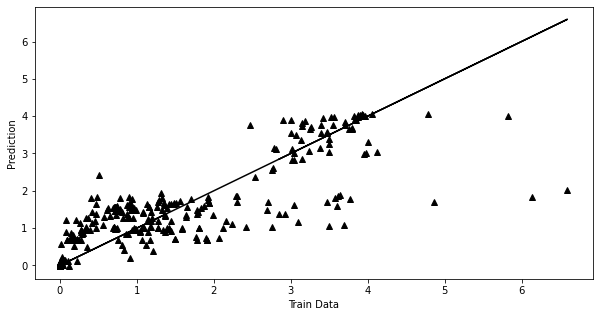

In [ ]:
# Parity plot with 45 degree reference line 
x = train_y
y = train_predictions

# colors = np.random.rand(N)
plt.figure(figsize=(10,5))
plt.plot(x,y, '^', color = "black") # x vs y
plt.plot(x,x,'k-') # identity line

plt.xlabel("Train Data")
plt.ylabel("Prediction")
# plt.xlim(0,6.5)
# plt.ylim(0,6.5)
# plt.savefig("/content/drive/My Drive/Figures_Paper2/Results_Sulphur/NeuralNetworks/NNtrain_smogn_sulphur.png") 
plt.show()
plt.close()